# Token Model Generator - vLLM Benchmark Format
Here we are making a statistical model of prefill/decode phases of the model.

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob
import re
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data = np.load("vllm-benchmark-llama-3-8b-power.npz", allow_pickle=True)

# turn the data into a pandas dataframe data =['timestamps',
#  'power_traces',
#  'prefill_tokens',
#  'decode_tokens',
#  'active_requests',
#  'input_tokens',
#  'output_tokens',
#  'ttfts',
#  'e2e_latencies',
#  'prefill_times',
#  'decode_times',
#  'prefill_throughputs',
#  'decode_throughputs',
#  'request_timestamps',
#  'tensor_parallelism',
#  'poisson_rate',
#  'model_sizes',
#  'hardware']
timestamps = data['timestamps']
power_traces = data['power_traces']
prefill_tokens = data['prefill_tokens']
decode_tokens = data['decode_tokens']
active_requests = data['active_requests']
input_tokens = data['input_tokens']
output_tokens = data['output_tokens']
ttfts = data['ttfts']
e2e_latencies = data['e2e_latencies']
prefill_times = data['prefill_times']
decode_times = data['decode_times']
prefill_throughputs = data['prefill_throughputs']
decode_throughputs = data['decode_throughputs']
request_timestamps = data['request_timestamps']
tensor_parallelism = data['tensor_parallelism']
poisson_rate = data['poisson_rate']
model_sizes = data['model_sizes']
hardware = data['hardware']

# create a pandas dataframe but flatten the data
df = pd.DataFrame({
    'timestamps': timestamps,
    'power_traces': power_traces,
    'prefill_tokens': prefill_tokens,
    'decode_tokens': decode_tokens,
    'active_requests': active_requests,
    'input_tokens': input_tokens,
    'output_tokens': output_tokens,
    'ttfts': ttfts,
    'e2e_latencies': e2e_latencies,
    'prefill_times': prefill_times,
    'decode_times': decode_times,
    'prefill_throughputs': prefill_throughputs,
    'decode_throughputs': decode_throughputs,
    'request_timestamps': request_timestamps,
    'tensor_parallelism': tensor_parallelism,
    'poisson_rate': poisson_rate,
    'model_sizes': model_sizes,
    'hardware': hardware
})
# print the dataframe
print(df.head())

ValueError: Per-column arrays must each be 1-dimensional

Found 853 CSV files in ../client
Found 287 power files and 566 results files
Found 287 power files, 566 results files, matched 275 pairs.
Filtered out 73 pairs. Remaining pairs: 202
Processing ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-04-27-01-09-03.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_2_d2025-04-27-01-09-03_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-04-27-01-09-03.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-04-27-07-25-12.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_4_d2025-04-27-07-25-12_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-04-27-07-25-12.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-04-27-06-04-31.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_4_d2025-04-27-06-04-31_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-04-27-06-04-31.csv
Processing ../client/llama-3-8b/lla

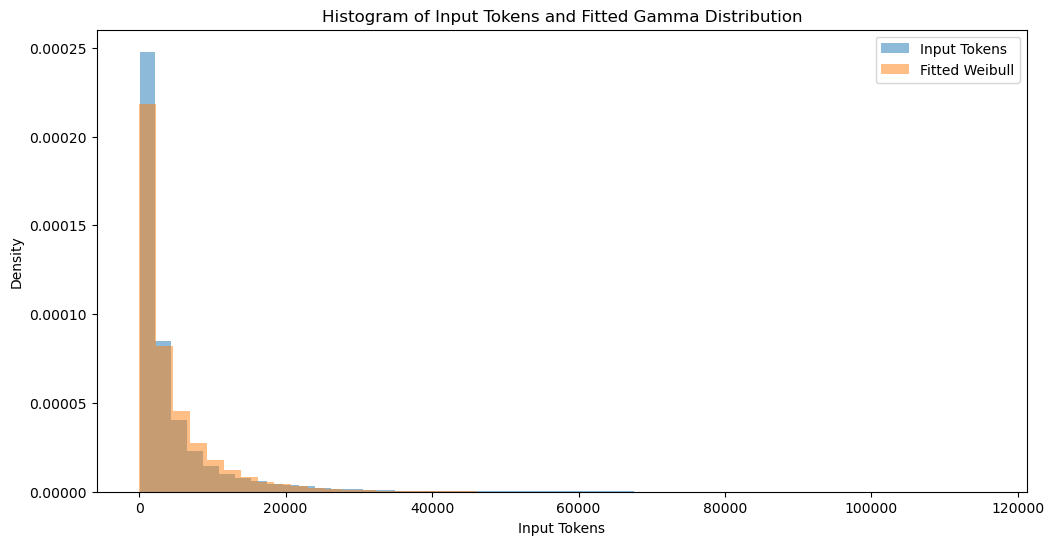

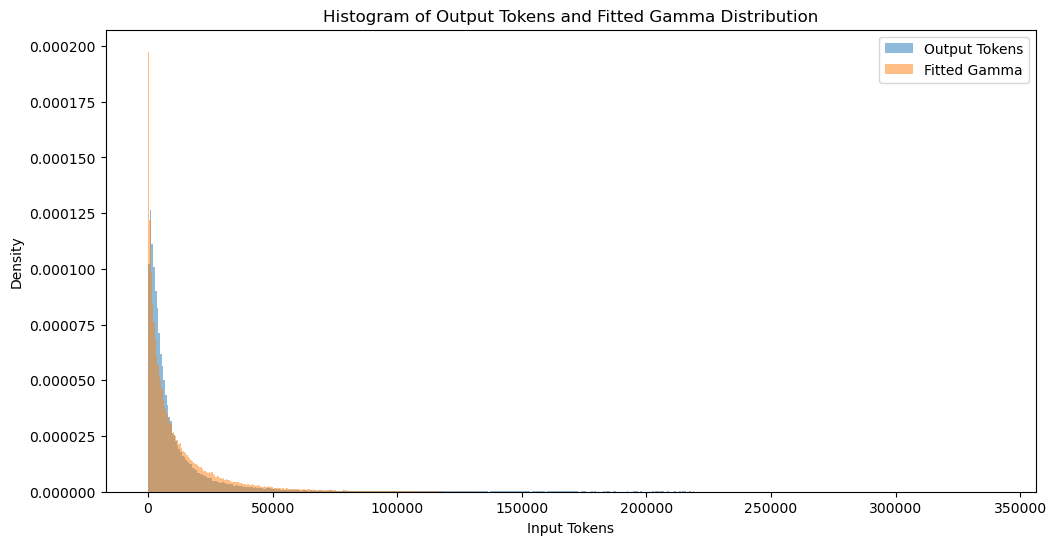

Error statistics for input tokens: {'Mean Relative Error': np.float64(0.18095367617088018), 'Median Relative Error': np.float64(0.1571059960860074), 'Max Relative Error': np.float64(0.9999940126883518)}
Error statistics for output tokens: {'Mean Relative Error': np.float64(0.24284436180601268), 'Median Relative Error': np.float64(0.2275725466361985), 'Max Relative Error': np.float64(0.999930556793702)}


In [103]:
input_tokens = []
output_tokens = []

for df in results_dfs:
    input_tokens.extend(df["Prefill Tokens"].tolist())
    output_tokens.extend(df["Decode Tokens"].tolist())

# Fit gamma distribution to input tokens
from scipy.stats import weibull_min
import numpy as np

# Convert to numpy arrays
input_tokens = np.array(input_tokens)
output_tokens = np.array(output_tokens)

# Fit Weibull distribution to input tokens
shape_input, loc_input, scale_input = weibull_min.fit(input_tokens, floc=0)
input_samples = weibull_min.rvs(shape_input, loc=loc_input, scale=scale_input, size=len(input_tokens))

# Fit Weibull distribution to output tokens
shape_output, loc_output, scale_output = weibull_min.fit(output_tokens, floc=0)
output_samples = weibull_min.rvs(shape_output, loc=loc_output, scale=scale_output, size=len(output_tokens))
# Plotting the histogram of input tokens and fitted distribution
plt.figure(figsize=(12, 6))
plt.hist(input_tokens, bins=50, alpha=0.5, label='Input Tokens', density=True)
plt.hist(input_samples, bins=50, alpha=0.5, label='Fitted Weibull', density=True)
plt.title("Histogram of Input Tokens and Fitted Gamma Distribution")
plt.xlabel("Input Tokens")
plt.ylabel("Density")
plt.legend()
plt.show()

# Generate and quantize output token samples

# Plotting the histogram of output tokens and fitted distribution
plt.figure(figsize=(12, 6))
plt.hist(output_tokens, bins=500, alpha=0.5, label='Output Tokens', density=True)
plt.hist(output_samples, bins=500, alpha=0.5, label='Fitted Gamma', density=True)
plt.title("Histogram of Output Tokens and Fitted Gamma Distribution")
plt.xlabel("Input Tokens")
plt.ylabel("Density")
plt.legend()
plt.show()

# Give error statistics based on quality of fit
def calculate_error_statistics(original_data, fitted_data):
    """
    Calculate relative error statistics between original and fitted data.
    
    Args:
        original_data: Original data (e.g., input tokens)
        fitted_data: Fitted data (e.g., gamma samples)
        
    Returns:
        A dictionary with relative error statistics.
    """
    # Calculate relative errors
    original_data = np.array(sorted(original_data))
    fitted_data = np.array(sorted(fitted_data))
    relative_errors = np.abs(original_data - fitted_data) / original_data
    
    # Calculate statistics on relative errors
    mean_relative_error = np.mean(relative_errors)
    median_relative_error = np.median(relative_errors)
    max_relative_error = np.max(relative_errors)
    
    return {
        "Mean Relative Error": mean_relative_error,
        "Median Relative Error": median_relative_error,
        "Max Relative Error": max_relative_error
    }

error_stats_input = calculate_error_statistics(input_tokens, input_samples)
error_stats_output = calculate_error_statistics(output_tokens, output_samples)
print(f"Error statistics for input tokens: {error_stats_input}")
print(f"Error statistics for output tokens: {error_stats_output}")

First 10 sample pairs (input, output):
Pair 1: (411, 3972)
Pair 2: (2294, 5281)
Pair 3: (1872, 1415)
Pair 4: (5087, 5306)
Pair 5: (11866, 23102)
Pair 6: (2652, 14250)
Pair 7: (1367, 16550)
Pair 8: (2744, 2436)
Pair 9: (637, 11677)
Pair 10: (8178, 316)


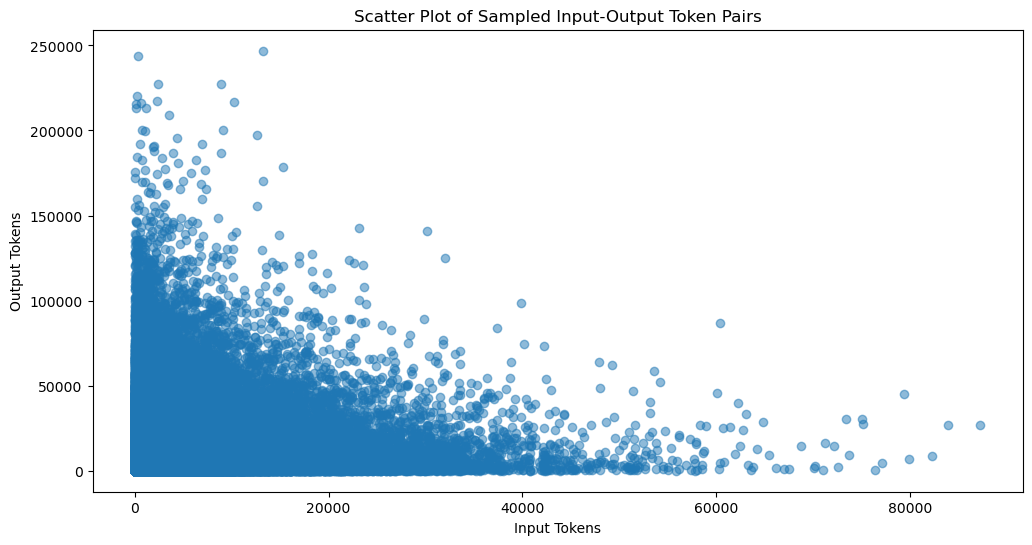

In [104]:
# Sample pairs from both gamma distributions
n_samples = 100000  # Number of sample pairs to generate

# Generate samples from input and output gamma distributions
input_samples = np.round(weibull_min.rvs(shape_input, loc=loc_input, scale=scale_input, size=n_samples)).astype(int)
output_samples = np.round(weibull_min.rvs(shape_output, loc=loc_output, scale=scale_output, size=n_samples)).astype(int)

# Create pairs and store in a list of tuples
sample_pairs = list(zip(input_samples, output_samples))

# Print first 10 pairs as example
print("First 10 sample pairs (input, output):")
for i, (inp, out) in enumerate(sample_pairs[:10]):
    print(f"Pair {i+1}: ({inp}, {out})")

# Plot scatter of sample pairs
plt.figure(figsize=(12, 6))
plt.scatter(input_samples, output_samples, alpha=0.5)
plt.title("Scatter Plot of Sampled Input-Output Token Pairs")
plt.xlabel("Input Tokens")
plt.ylabel("Output Tokens")
plt.show()


Now we have some distributions of our input and output token relationships for our models with relatively high accuracy. We can use these distributions to simulate arrivals to a prefill/decode phase of the model. This is a simple simulation of the model, but it can be used to generate a large number of samples for training and testing purposes.

In [60]:
import seaborn as sns
df_all = pd.concat(results_dfs, ignore_index=True)
mean_prefill_throughputs = df_all["Prefill Throughput"].groupby([df_all["Model"], df_all["Tensor Parallel Size"]]).mean()
print(mean_prefill_throughputs)

mean_decode_throughputs = df_all["Decode Throughput"].groupby([df_all["Model"], df_all["Tensor Parallel Size"]]).mean()
print(mean_decode_throughputs)

mean_batch_sizes = df_all["Batch Size"].groupby([df_all["Model"], df_all["Tensor Parallel Size"]]).mean()
print(mean_batch_sizes)

df_8b = df_all[df_all["Model"] == "meta-llama/Llama-3.1-8B-Instruct"]
df_70b = df_all[df_all["Model"] == "meta-llama/Llama-3.1-70B-Instruct"]


Model                              Tensor Parallel Size
meta-llama/Llama-3.1-70B-Instruct  4                        3116.696288
                                   8                        4587.457790
meta-llama/Llama-3.1-8B-Instruct   1                        5596.142427
                                   2                       10618.075151
                                   4                       14624.384907
                                   8                       16832.132544
Name: Prefill Throughput, dtype: float64
Model                              Tensor Parallel Size
meta-llama/Llama-3.1-70B-Instruct  4                        37.814404
                                   8                        59.125723
meta-llama/Llama-3.1-8B-Instruct   1                       135.523747
                                   2                       198.189926
                                   4                       274.465478
                                   8                       347.39

As we can see, the decode and prefill throughputs split by TP and model size are gamma distributed. Now we need to see if they are truly random within their evolution over time.

In [70]:
from scipy.stats import pearsonr
# copy_df["Prefill Throughput"] /= copy_df["Prefill Throughput"].max()
# copy_df["Decode Throughput"] /= copy_df["Decode Throughput"].max()
# copy_df["Prefill Tokens"] /= copy_df["Prefill Tokens"].max()
# copy_df["Decode Tokens"] /= copy_df["Decode Tokens"].max()

# show me where my df_all "Prefill Time" is NaN
df_all = df_all[~df_all["Prefill Time"].isna()]
df_8b = df_8b[~df_8b["Prefill Time"].isna()]
df_70b = df_70b[~df_70b["Prefill Time"].isna()]
# print("Rows with NaN Prefill Time:")
# # find specific unique groupings of Tensor Parallel Size, Model, Poisson Arrival Rate in nan_prefill_time
# nan_prefill_time_grouped = nan_prefill_time.groupby(["Tensor Parallel Size", "Model", "Poisson Arrival Rate"]).size().reset_index(name='counts')
# print(nan_prefill_time_grouped)

pearson_corr = pearsonr(df_all["Prefill Tokens"], df_all["Prefill Time"])
print(f"Pearson correlation coefficient: {pearson_corr[0]}")

pearson_corr = pearsonr(df_70b["Decode Tokens"], df_70b["Decode Time"])
print(f"Pearson correlation coefficient: {pearson_corr[0]}")

Pearson correlation coefficient: 0.8776718433701621
Pearson correlation coefficient: 0.9424476429358855


We can see there is almost no correlation between prefill/decode tokens and prefill/decode throughput. Therefore, we can fit a Gamma distribution for each of our models and tensor parallelisms and draw from them to simulate the prefill/decode phases.

In [ ]:
# Fit a gamma distribution to the Prefill Throughput
from scipy.stats import gamma
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Function to fit gamma distribution using method of moments
def fit_lognormal_moments(data):
    # Convert to log space
    log_data = np.log(data)
    # Calculate parameters
    mu = np.mean(log_data)  # location parameter
    sigma = np.std(log_data)  # scale parameter
    return mu, sigma

# Create dictionaries to store parameters for each model and TP
# prefill_params = {}
# decode_params = {}

# # Fit for 8B model
# for tp in df_8b['Tensor Parallel Size'].unique():
#     # Prefill
#     prefill_data = df_8b[df_8b['Tensor Parallel Size'] == tp]['Prefill Throughput']
#     mu, sigma = fit_lognormal_moments(prefill_data)
#     prefill_params[('8B', tp)] = (mu, sigma)
    
#     # Decode
#     decode_data = df_8b[df_8b['Tensor Parallel Size'] == tp]['Decode Throughput']
#     mu, sigma = fit_lognormal_moments(decode_data)
#     decode_params[('8B', tp)] = (mu, sigma)

# # Fit for 70B model
# for tp in df_70b['Tensor Parallel Size'].unique():
#     # Prefill
#     prefill_data = df_70b[df_70b['Tensor Parallel Size'] == tp]['Prefill Throughput']
#     mu, sigma = fit_lognormal_moments(prefill_data)
#     prefill_params[('70B', tp)] = (mu, sigma)
    
#     # Decode
#     decode_data = df_70b[df_70b['Tensor Parallel Size'] == tp]['Decode Throughput']
#     mu, sigma = fit_lognormal_moments(decode_data)
#     decode_params[('70B', tp)] = (mu, sigma)


                            OLS Regression Results                            
Dep. Variable:           Prefill Time   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 2.297e+05
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        15:57:35   Log-Likelihood:                 27155.
No. Observations:               22407   AIC:                        -5.431e+04
Df Residuals:                   22405   BIC:                        -5.429e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0049      0.001      8.

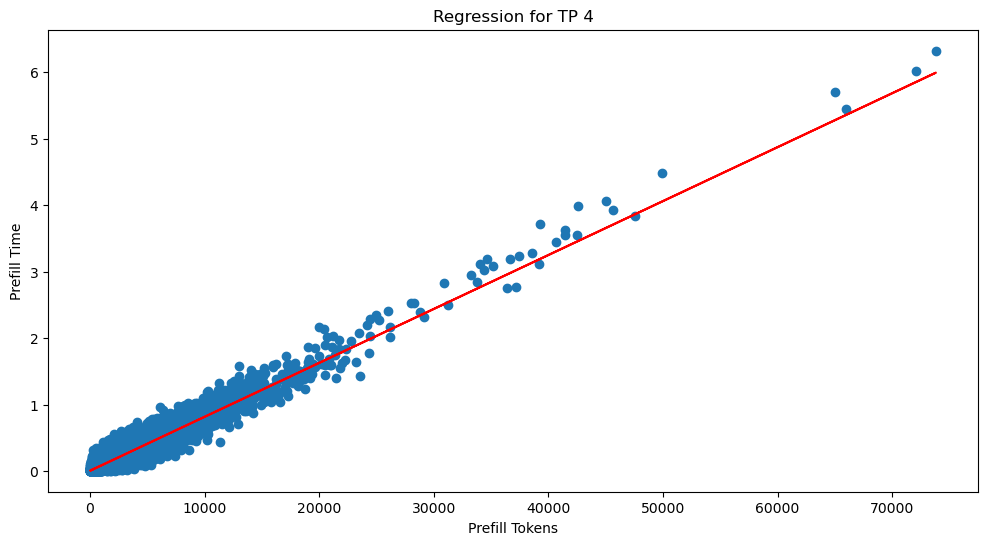

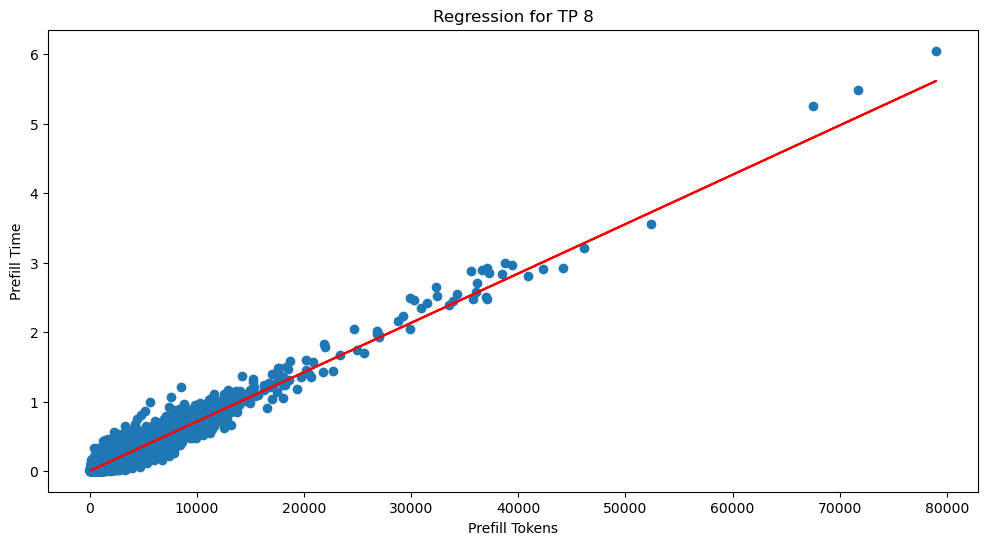

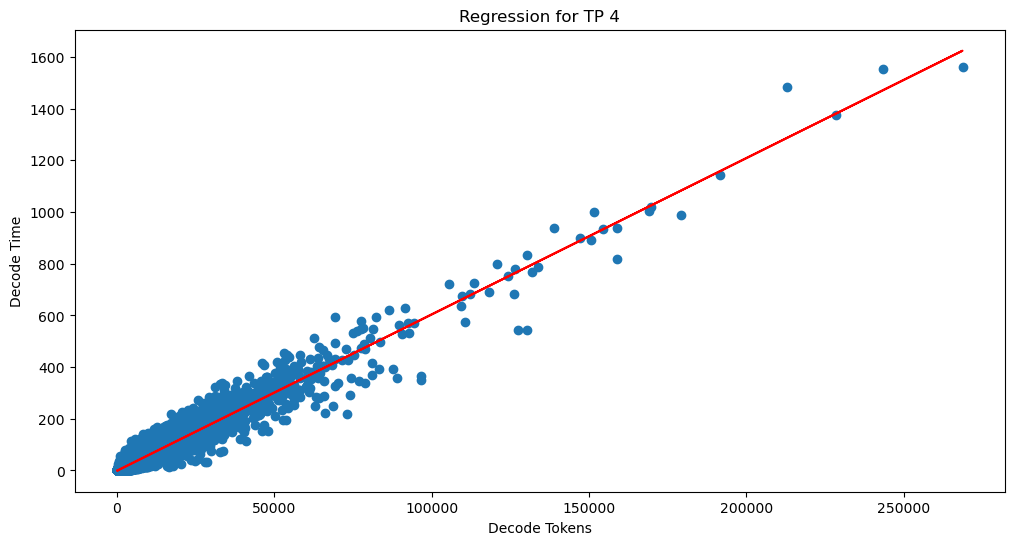

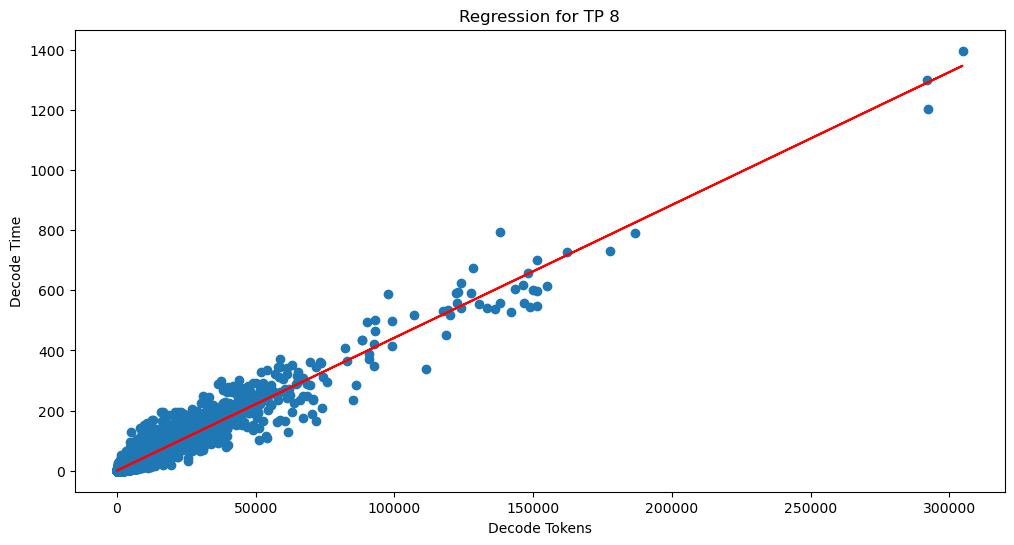

In [72]:
import statsmodels.api as sm

prefill_params = {}
for tp in [4, 8]:
    prefill_data = df_8b[df_8b["Tensor Parallel Size"] == tp]["Prefill Time"]
    prefill_tokens = df_8b[df_8b["Tensor Parallel Size"] == tp]["Prefill Tokens"]
    model = sm.OLS(prefill_data, sm.add_constant(prefill_tokens)).fit()
    prefill_params[("8B", tp)] = model.params
    print(model.summary())
    # decode_data = df_8b[df_8b["Tensor Parallel Size"] == tp]["Decode Time"]
    plt.figure(figsize=(12, 6))
    plt.scatter(prefill_tokens, prefill_data, label="Data")
    plt.plot(prefill_tokens, model.predict(sm.add_constant(prefill_tokens)), color='red', label="Regression Line")
    plt.title(f"Regression for TP {tp}")
    plt.xlabel("Prefill Tokens")
    plt.ylabel("Prefill Time")

decode_params = {}
for tp in [4,8]:
    decode_data = df_8b[df_8b["Tensor Parallel Size"] == tp]["Decode Time"]
    decode_tokens = df_8b[df_8b["Tensor Parallel Size"] == tp]["Decode Tokens"]
    model = sm.OLS(decode_data, sm.add_constant(decode_tokens)).fit()
    decode_params[("8B", tp)] = model.params
    print(model.summary())
    plt.figure(figsize=(12, 6))
    plt.scatter(decode_tokens, decode_data, label="Data")
    plt.plot(decode_tokens, model.predict(sm.add_constant(decode_tokens)), color='red', label="Regression Line")
    plt.title(f"Regression for TP {tp}")
    plt.xlabel("Decode Tokens")
    plt.ylabel("Decode Time")

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_52094/83550506.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prefill_time = prefill_time_params[0] + prefill_time_params[1] * input_tokens_sample
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_52094/83550506.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  decode_time = decode_time_params[0] + decode_time_params[1] * output_tokens_sample


Lengths of lists:
Arrival Times: 984
Start Times: 984
Input Tokens: 984
Output Tokens: 984
Prefill Times: 984
Decode Times: 984
Completion Times: 984
Prefill Throughputs: 0
Decode Throughputs: 0


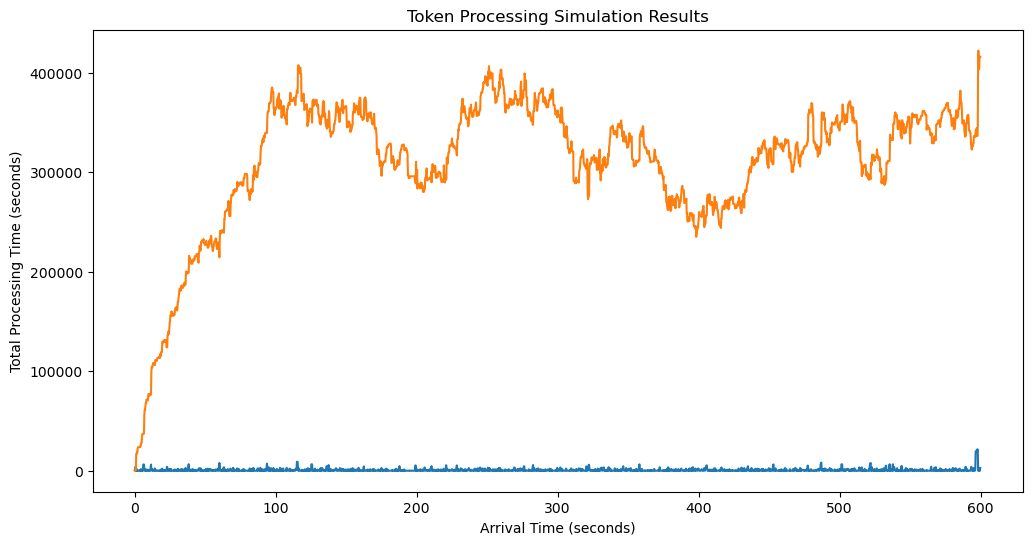

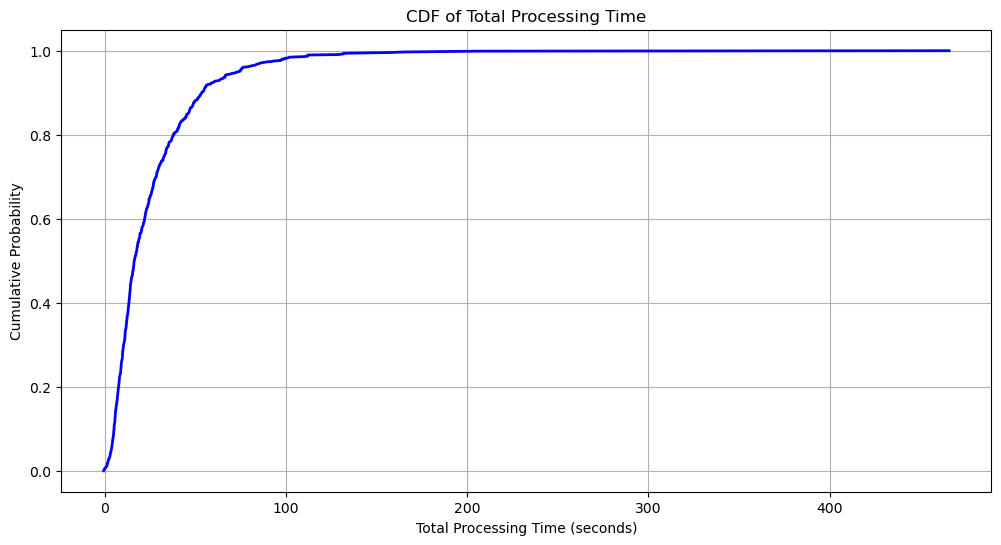


Simulation Summary Statistics:
Total requests processed: 984
Average processing time: 25.33 seconds
Average input tokens: 1260.13
Average output tokens: 4333.99
Average queue time: 11912.42 seconds
Max processing time: 465.88 seconds
P90 processing time: 53.61 seconds
P99 processing time: 114.88 seconds


In [99]:
import random

def simulate_token_processing(arrival_rate, simulation_time, sample_pairs, model, tensor_parallel_size, delta_t=0.25):
    # Initialize lists to store results
    arrival_times = []
    input_tokens = []
    output_tokens = []
    prefill_times = []
    decode_times = []
    start_times = []
    completion_times = []
    prefill_throughputs = []
    decode_throughputs = []
    model_size = model.split("-")[-2]
    prefill_time_params = prefill_params[(model_size, tensor_parallel_size)]
    decode_time_params = decode_params[(model_size, tensor_parallel_size)]
    
    # Generate arrivals using discrete time steps
    current_time = 0
    while current_time < simulation_time:
        # Calculate probability of arrival in this time step
        prob_arrival = 1 - np.exp(-arrival_rate * delta_t)
        
        if np.random.random() < prob_arrival:
            input_tokens_sample, output_tokens_sample = random.choice(sample_pairs)
            
            prefill_time = prefill_time_params[0] + prefill_time_params[1] * input_tokens_sample
            decode_time = decode_time_params[0] + decode_time_params[1] * output_tokens_sample
            # Store results
            arrival_times.append(current_time)
            input_tokens.append(input_tokens_sample)
            output_tokens.append(output_tokens_sample)
            prefill_times.append(prefill_time)
            decode_times.append(decode_time)
        
        current_time += delta_t
    
    # Process requests in order of arrival
    current_time = 0
    prefill_tokens_at_time = []  # Track prefill tokens at each time step
    decode_tokens_at_time = []   # Track decode tokens at each time step
    time_steps = np.arange(0, simulation_time, delta_t)
    
    for t in time_steps:
        prefill_tokens = 0
        decode_tokens = 0
        
        # Check each request to see if it's being processed at this time
        for i in range(len(arrival_times)):
            start_time = max(arrival_times[i], current_time)
            completion_time = start_time + prefill_times[i] + decode_times[i]
            
            if start_time <= t < start_time + prefill_times[i]:
                # Request is in prefill phase
                prefill_tokens += input_tokens[i]
            elif start_time + prefill_times[i] <= t < completion_time:
                # Request is in decode phase
                decode_tokens += output_tokens[i]
        
        prefill_tokens_at_time.append(prefill_tokens)
        decode_tokens_at_time.append(decode_tokens)
    
    # Process requests in order of arrival for completion times
    current_time = 0
    for i in range(len(arrival_times)):
        start_time = max(arrival_times[i], current_time)
        completion_time = start_time + prefill_times[i] + decode_times[i]
        current_time = completion_time
        
        start_times.append(start_time)
        completion_times.append(completion_time)
    # Debugging: Check lengths of all lists
    print("Lengths of lists:")
    print(f"Arrival Times: {len(arrival_times)}")
    print(f"Start Times: {len(start_times)}")
    print(f"Input Tokens: {len(input_tokens)}")
    print(f"Output Tokens: {len(output_tokens)}")
    print(f"Prefill Times: {len(prefill_times)}")
    print(f"Decode Times: {len(decode_times)}")
    print(f"Completion Times: {len(completion_times)}")
    print(f"Prefill Throughputs: {len(prefill_throughputs)}")
    print(f"Decode Throughputs: {len(decode_throughputs)}")

    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Arrival Time': arrival_times,
        'Start Time': start_times,
        'Input Tokens': input_tokens,
        'Output Tokens': output_tokens,
        'Prefill Time': prefill_times,
        'Decode Time': decode_times,
        'Total Processing Time': [p + d for p, d in zip(prefill_times, decode_times)],
        'Completion Time': completion_times,
        'Queue Time': [s - a for s, a in zip(start_times, arrival_times)]
    })

    tokens_at_time_df = pd.DataFrame({
        'Time': time_steps,
        'Prefill Tokens at Time': prefill_tokens_at_time,
        'Decode Tokens at Time': decode_tokens_at_time
    })
    
    return results_df, tokens_at_time_df

# build sample pairs from existing data
sample_pairs = []
copy_df = df_8b[df_8b["Tensor Parallel Size"] == 4]
copy_df = copy_df[copy_df["Poisson Arrival Rate"] == 2.0]
for i in range(len(copy_df)):
    input_tokens = copy_df.iloc[i]["Prefill Tokens"]
    output_tokens = copy_df.iloc[i]["Decode Tokens"]
    sample_pairs.append((input_tokens, output_tokens))

# Run simulation with example parameters
arrival_rate = 2  # requests per second
simulation_time = 600  # seconds
sim_results, sim_tokens = simulate_token_processing(arrival_rate, simulation_time, sample_pairs, "meta-llama/Llama-3.1-8B-Instruct", 4)

# plt.plot(results_dfs[0]["Request Time"],results_dfs[0]['Prefill Tokens'])
# plt.plot(results_dfs[0]["Request Time"],results_dfs[0]['Decode Tokens'])
plt.figure(figsize=(12, 6))
plt.plot(sim_tokens['Time'], sim_tokens['Prefill Tokens at Time'], label='Prefill Tokens at Time')
plt.plot(sim_tokens['Time'], sim_tokens['Decode Tokens at Time'], label='Decode Tokens at Time')
plt.title('Token Processing Simulation Results')
plt.xlabel('Arrival Time (seconds)')
plt.ylabel('Total Processing Time (seconds)')
plt.show()

# Calculate CDF of total processing time
sorted_times = np.sort(sim_results['Total Processing Time'])
cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)

plt.figure(figsize=(12, 6))
plt.plot(sorted_times, cdf, 'b-', linewidth=2)
plt.title('CDF of Total Processing Time')
plt.xlabel('Total Processing Time (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


# Print summary statistics
print("\nSimulation Summary Statistics:")
print(f"Total requests processed: {len(sim_results)}")
print(f"Average processing time: {sim_results['Total Processing Time'].mean():.2f} seconds")
print(f"Average input tokens: {sim_results['Input Tokens'].mean():.2f}")
print(f"Average output tokens: {sim_results['Output Tokens'].mean():.2f}")
print(f"Average queue time: {sim_results['Queue Time'].mean():.2f} seconds")

print(f"Max processing time: {sim_results['Total Processing Time'].max():.2f} seconds")
print(f"P90 processing time: {np.percentile(sim_results['Total Processing Time'], 90):.2f} seconds")
print(f"P99 processing time: {np.percentile(sim_results['Total Processing Time'], 99):.2f} seconds")



Text(0, 0.5, 'Cumulative Probability')

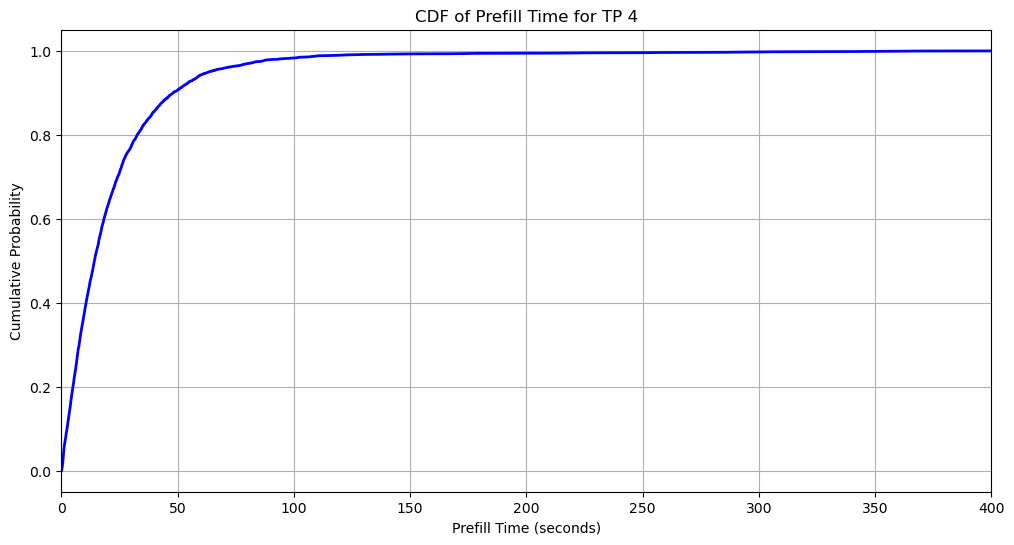

In [102]:
# plot CDF of total processing time of tp 4 df_8b with arrival rate of 2.0
# Calculate CDF of total processing time
copy_df = df_8b[df_8b["Tensor Parallel Size"] == 4]
copy_df = copy_df[copy_df["Poisson Arrival Rate"] == 2.0]
copy_df["Total Processing Time"] = copy_df["Prefill Time"] + copy_df["Decode Time"]
sorted_times = np.sort(copy_df['Total Processing Time'])
cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(sorted_times, cdf, 'b-', linewidth=2)
plt.xlim(0,400)
plt.title('CDF of Prefill Time for TP 4')
plt.xlabel('Prefill Time (seconds)')
plt.ylabel('Cumulative Probability')

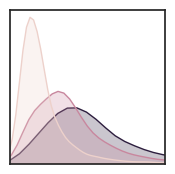

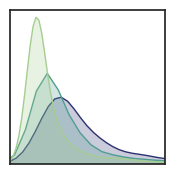

In [305]:
# plot the lognormal distribution of prefill and decode throughput
plt.figure(figsize=(2, 2))
sns.set_palette("colorblind")
sns.kdeplot(
    data=df_8b[df_8b["Tensor Parallel Size"] != 8],
    x="Prefill Throughput",
    hue="Tensor Parallel Size",
    fill=True,
    common_norm=False,
    legend=False,
)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xlim(0, 25e3)
plt.savefig("prefill_throughput.pdf", bbox_inches="tight")

plt.figure(figsize=(2, 2))
sns.set_palette("colorblind")
sns.kdeplot(
    data=df_8b[df_8b["Tensor Parallel Size"] != 8],
    x="Decode Throughput",
    hue="Tensor Parallel Size",
    fill=True,
    common_norm=False,
    legend=False,
    palette="crest",
)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xlim(0, 5e2)
plt.savefig("decode_throughput.pdf", bbox_inches="tight")


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_67960/2309333619.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_all,
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_67960/2309333619.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_all,


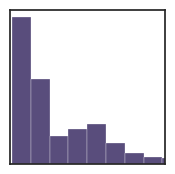

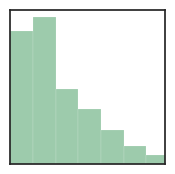

In [307]:
# plot the input and output tokens distribution
plt.figure(figsize=(2, 2))
sns.set(palette="magma", style="white")
sns.histplot(data=df_all,
    x="Input Tokens",
    legend=False,
    bins=50,
    palette="magma",
)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xlim(0, 350)
plt.savefig("input_tokens.pdf", bbox_inches="tight")

plt.figure(figsize=(2, 2))
sns.set(palette="crest", style="white")
sns.histplot(data=df_all,
    x="Output Tokens",
    legend=False,
    bins=100,
    palette="crest",
)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xlim(0, 1e3)
plt.savefig("output_tokens.pdf", bbox_inches="tight")

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_67960/598501991.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=copy_df,


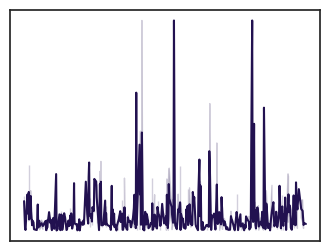

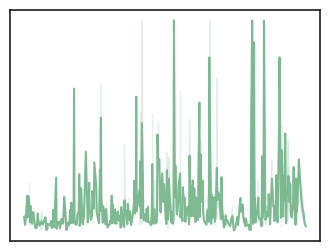

In [327]:
copy_df = results_dfs[10].copy()
copy_df["Prefill Tokens"] = copy_df["Prefill Tokens"].clip(upper=7.5e3)
copy_df["Decode Tokens"] = copy_df["Decode Tokens"].clip(upper=1.5e4)
sns.set(palette="magma", style="white")
plt.figure(figsize=(4, 3))
sns.lineplot(
    data=copy_df,
    x="Request Time",
    y="Prefill Tokens",
    markers=True,
    dashes=False,
)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.savefig("prefill_tokens.pdf", bbox_inches="tight")

plt.figure(figsize=(4, 3))
copy_df = results_dfs[10].copy()
copy_df["Decode Tokens"] = copy_df["Decode Tokens"].clip(upper=1.5e4)
sns.set(palette="crest", style="white")
sns.lineplot(data=copy_df,
             x="Request Time",
                y="Decode Tokens",
                markers=True,
                dashes=False,
                palette="crest")
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.savefig("decode_tokens.pdf", bbox_inches="tight")

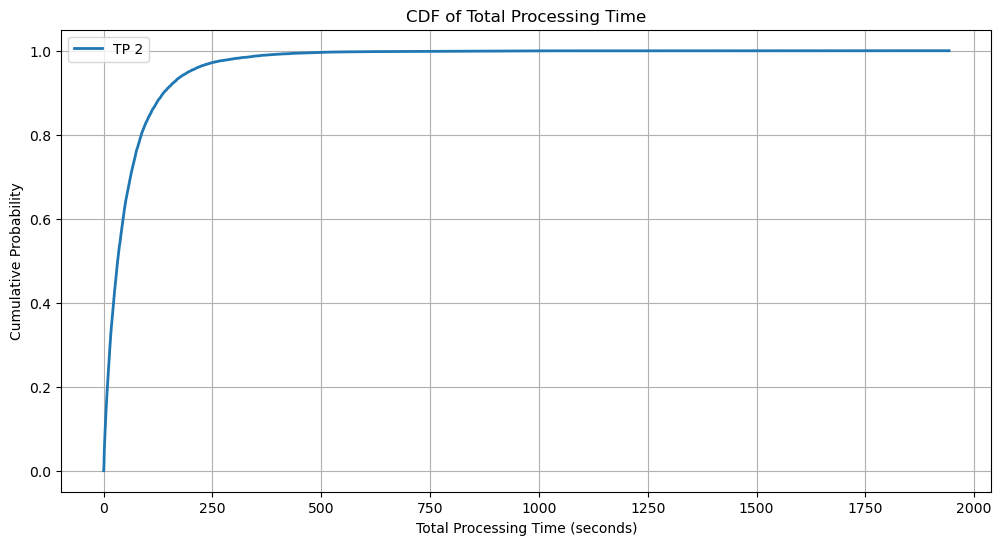

In [52]:
# Plot the distribution of prefill time / prefill tokens, filtering out all of the NaNs and split by tensor parallel size
import scipy.stats as stats
import seaborn as sns

df_copy = df_8b.copy()
df_copy["Total Time"] = df_copy["Prefill Time"] + df_copy["Decode Time"]
# make a cdf of the e2e latency, split over tensor parallelism in Seaborn
plt.figure(figsize=(12, 6))

tp_df = df_copy[df_copy["Tensor Parallel Size"] == 2]
total_times = tp_df["Total Time"].dropna().values
sorted_times = np.sort(total_times)
cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
plt.plot(sorted_times, cdf, linewidth=2, label=f"TP {2}")
plt.title('CDF of Total Processing Time')
plt.xlabel('Total Processing Time (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)

plt.legend()

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_52094/357517683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_df["Throughput"] = (tp_df["Input Tokens"] + tp_df["Output Tokens"]) / (tp_df["Prefill Time"] + tp_df["Decode Time"])
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_52094/357517683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_df["Total Time"] = tp_df["Prefill Time"] + tp_df["Decode Time"]
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_52094/357517

<Axes: xlabel='Input Tokens', ylabel='Throughput'>

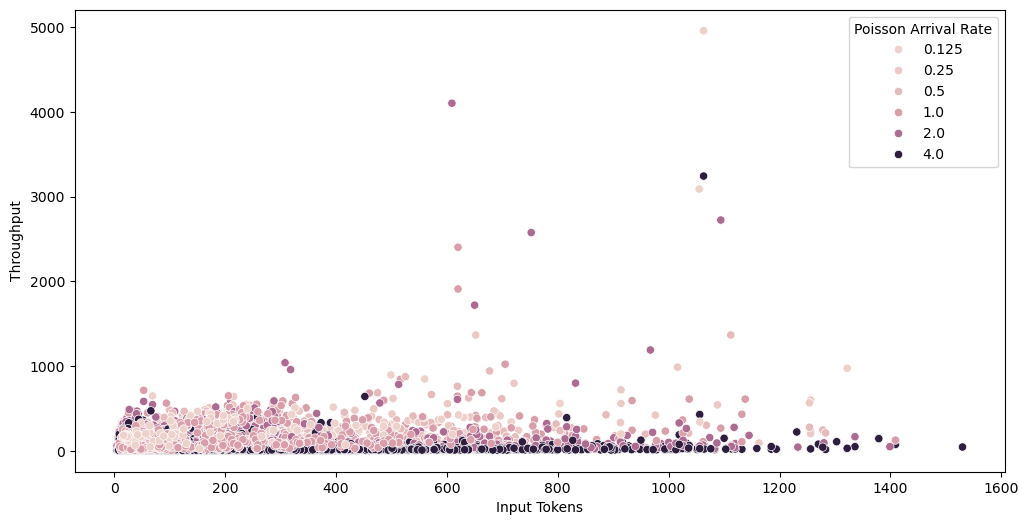

In [213]:
import statsmodels.api as sm
plt.figure(figsize=(12,6))
tp_df = df_copy[df_copy["Tensor Parallel Size"] == 4]
tp_df["Throughput"] = (tp_df["Input Tokens"] + tp_df["Output Tokens"]) / (tp_df["Prefill Time"] + tp_df["Decode Time"])
# X = (tp_df["Input Tokens"])
# y = tp_df["Throughput"]
tp_df["Total Time"] = tp_df["Prefill Time"] + tp_df["Decode Time"]
tp_df["Total Tokens"] = tp_df["Input Tokens"] + tp_df["Output Tokens"]
# model = sm.OLS(y, sm.add_constant(X)).fit()
# print(model.summary())
sns.scatterplot(data=tp_df, x="Input Tokens", y="Throughput", hue="Poisson Arrival Rate")
# plt.plot(X, model.predict(sm.add_constant(X)), color='red', label="Regression Line")
# sm.OLS(tp_df["Throughput"], sm.add_constant(tp_df["Prefill Tokens"])).fit().summary()
# plt.title('Batch Size vs Total Tokens')
# plt.show()

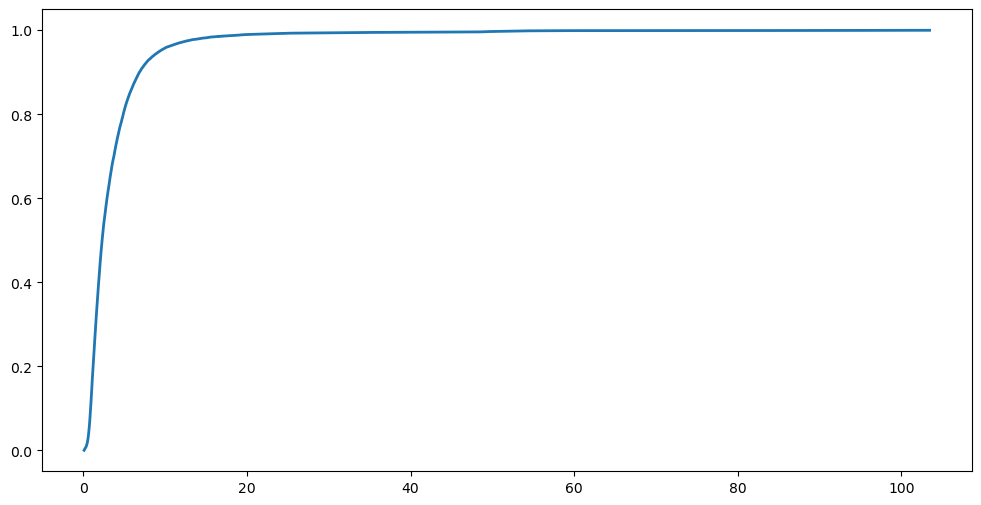

In [171]:
# make cdf of e2e latency in tp_df
plt.figure(figsize=(12, 6))

